In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
def convertToPixel_LowRes(zoomout_Stagex, zoomout_Stagey, centerPixel_x, centerPixel_y, dXpos, dYpos, pixel_resolution):
    import numpy as np
    
    delStage_x = zoomout_Stagex - dXpos
    delStage_y = zoomout_Stagey - dYpos

    delPixel_x = delStage_x*pixel_resolution
    delPixel_y = delStage_y*pixel_resolution

    pix_x = int(np.round(centerPixel_x + delPixel_x))
    pix_y = int(np.round(centerPixel_y - delPixel_y)) # subtract it because the y axis is inverted!
#     pix_x = int(np.round(centerPixel_x/dXpos * glob_x))
#     pix_y = int(np.round(centerPixel_y/dYpos * glob_y))
    return(pix_x, pix_y)

In [3]:
def getXYPosSingle(path):
    ## this returns position for single images
    from nd2reader import ND2Reader
    from nd2reader.raw_metadata import RawMetadata
    
    # get label map
    with ND2Reader(path) as images:
        mp = images._parser._label_map
    
    fh = open(path, 'rb')
    y = RawMetadata(fh, mp).y_data
    x = RawMetadata(fh, mp).x_data
    
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    if images.metadata['fields_of_view'][0] > 0:
        print('check input file')
    
    return(mean_x, mean_y)

In [4]:
def getCenterPixel(path):
    from nd2reader import ND2Reader
    # assuming the x and y coordinates of a single image in the metaData
    # corresponds to the middle of the frame: read SizeX, SizeY
    with ND2Reader(path) as images:
        num_pixel_x = images.metadata['width']
        num_pixel_y = images.metadata['height']

    c_x = num_pixel_x/2
    c_y = num_pixel_y/2
    return(c_x, c_y)

In [5]:
resolution = 0.6154 # in pixels/micron

### Pick the file to analyze and input the offset values

In [6]:
# position of CS in microns from the file created in previous Step - "00_ReadHeaderAndMakeList"
input_location = r"D:/Wing Imaging/"
locationAnalysisData = './dataFolder/Analysis/'

In [7]:
# list of folders & filename 
# MyList = [('2021_09_16','m2_ventFW_full.nd2'),
#                       ('2021_09_17','M2_dorsFW_full.nd2'),
#                       ('2021_09_22','m3_dorsHW_full.nd2'),
#                       ('2021_09_22', 'm3_ventHW_full.nd2'),
#                       ('2021_10_16', 'm4_dorsHW_full.nd2'),
#                       ('2021_10_16', 'm4_ventHW_full.nd2')]

MyList = [
    ('2021_11_16','m6_ventFW_full.nd2'),
    ('2021_11_21','m6_dorsFW_full.nd2'),
    ('2021_11_30','m7_dorsFW_full.nd2'),
    ('2021_12_07', 'M7_ventFW_full.nd2'),
    ('2021_12_12', 'm8_dorsFW_fulll.nd2'),
    ('2021_12_17', 'm8_ventFW_allpoints.nd2')
    ]

In [8]:
MyList[5][0], MyList[5][1]

('2021_12_17', 'm8_ventFW_allpoints.nd2')

## run the rest of the lines for all the files

In [11]:
locationImageData = input_location + MyList[5][0] + '/'
filename = MyList[5][1]

In [12]:
## get the offset values 
## - commented out right now because offset values are the same across all days
## if offset value doesn't match then uncomment and run this cell

# offset_x = None
# while offset_x is None:
#     try:
#         offset_x = float(input("Enter the offset for x axis, in microns): "))
#     except ValueError:
#         print("Not an integer value...")

# offset_y = None
# while offset_y is None:
#     try:
#         offset_y = float(input("Enter the offset for y axis, in microns: "))
#     except ValueError:
#         print("Not an integer value...")

# print('offset for x and y is %.3f & %.3f microns respectively' %(offset_x, offset_y))

In [13]:
offset_x = 6.5
offset_y = -44.7

### get information from the full image at 4X
centerPixel_x,centerPixel_y = getCenterPixel(locationImageData + filename)
zoom_out_dXpos, zoom_out_dYpos = getXYPosSingle(locationImageData + filename)

### get the list of points in 10X that need to be transformed
moth, side, _ = filename.split('_')
path = glob.glob(locationAnalysisData + moth + '_' + side + '_al*.csv')[0]
df = pd.read_csv(path)

### transform away!
fullW_x = []
fullW_y = []

for index, row in df.iterrows():
# for x, y in :
    new_x = row['x_highRes'] - offset_x
    new_y = row['y_highRes'] - offset_y

    zoomOut_pix_x, zoomOut_pix_y = convertToPixel_LowRes(zoom_out_dXpos, zoom_out_dYpos,
                                                     centerPixel_x, centerPixel_y,   
                                                     new_x, new_y, 
                                                     resolution)
    fullW_x.append(zoomOut_pix_x)
    fullW_y.append(zoomOut_pix_y)

# save in the same dataframe and export
df['zoomOut_x(Pixel)'] = fullW_x
df['zoomOut_y(Pixel)'] = fullW_y
df.to_csv(locationAnalysisData + moth + '_' + side + '_zoomOut.csv', index = False)

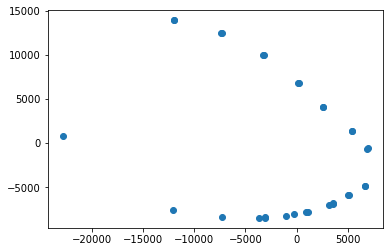

In [30]:
import matplotlib.pyplot as plt

plt.plot(df.x_highRes, df.y_highRes, 'o')